In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
data_1 = pd.read_csv("/content/drive/My Drive/df_fe_without_preprocessing_train.csv", encoding='latin-1').drop(["qid1","qid2","question1","question2","is_duplicate"], axis=1)
data_2 = pd.read_csv("/content/drive/My Drive/nlp_features_train.csv", encoding='latin-1')

In [41]:
print(data_1.shape)
print(data_2.shape)

(404290, 12)
(404290, 21)


In [0]:
data = data_2.merge(data_1, on = "id",how = "left").sample(50000)

In [43]:
data.fillna(" ", inplace=True)
data.shape

(50000, 32)

In [44]:
y_true = data["is_duplicate"].values
data.drop("is_duplicate",axis=1, inplace=True)
print(data.shape)
print(y_true.shape)

(50000, 31)
(50000,)


<h2> 4.3 Random train test split( 70:30) </h2>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [62]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 31)
Number of data points in test data : (15000, 31)


In [63]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6357714285714285 Class 1:  0.3642285714285714
---------- Distribution of output variable in train data ----------
Class 0:  0.3642 Class 1:  0.3642


In [68]:
X_train.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
364740,0.999986,0.874989,0.999967,0.999967,0.909083,0.833326,1.0,1.0,1.0,11.5,100,94,94,93,0.853659,1,1,81,92,11,12,10.0,21.0,0.47619,2,0


In [69]:
X_test.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
371489,0.749981,0.749981,0.499988,0.499988,0.624992,0.624992,1.0,1.0,0.0,8.0,83,69,75,69,0.555556,3,2,35,39,8,8,5.0,16.0,0.3125,5,1


In [65]:
X_train.isnull().values.any()

False

In [0]:
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score.
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
tfidf_q1_train = tfidf.transform(X_train["question1"].values)
tfidf_q2_train = tfidf.transform(X_train["question2"].values)
tfidf_q1_test = tfidf.transform(X_test["question1"].values)
tfidf_q2_test = tfidf.transform(X_test["question2"].values)

In [0]:
q1_train = X_train["question1"].values
q2_train = X_train["question2"].values
q1_test = X_test["question1"].values
q2_test = X_test["question2"].values

In [0]:
X_train.drop(["id","qid1","qid2","question1","question2"],axis=1,inplace=True)
X_test.drop(["id","qid1","qid2","question1","question2"],axis=1,inplace=True)

In [0]:
from scipy.sparse import hstack

x_train_1 = hstack((X_train,tfidf_q1_train,tfidf_q2_train))
x_test_1 = hstack((X_test,tfidf_q1_test,tfidf_q2_test))

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8739858912925922


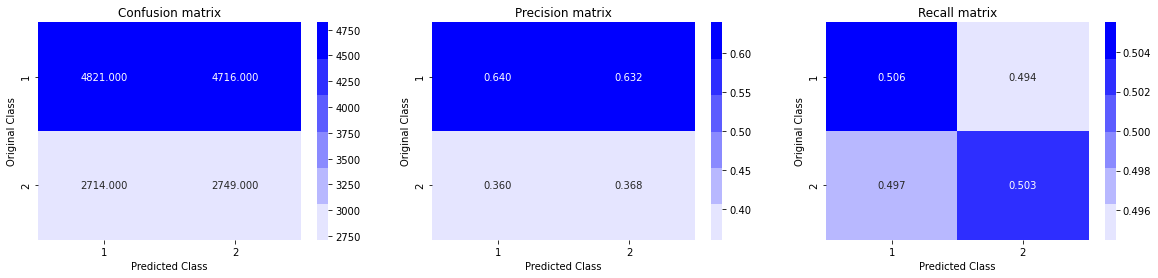

In [94]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.41949658720263505
For values of alpha =  0.0001 The log loss is: 0.42832596918254684
For values of alpha =  0.001 The log loss is: 0.43099119181887346
For values of alpha =  0.01 The log loss is: 0.4438815467808198
For values of alpha =  0.1 The log loss is: 0.45872353337620003
For values of alpha =  1 The log loss is: 0.4928629793123055
For values of alpha =  10 The log loss is: 0.5423743919010556


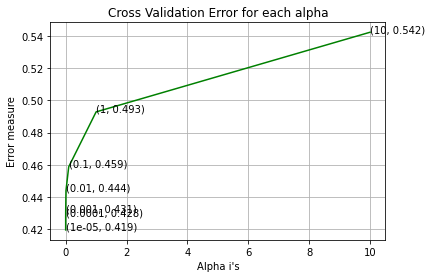

For values of best alpha =  1e-05 The train log loss is: 0.4117833385001657
For values of best alpha =  1e-05 The test log loss is: 0.41949658720263505
Total number of data points : 15000


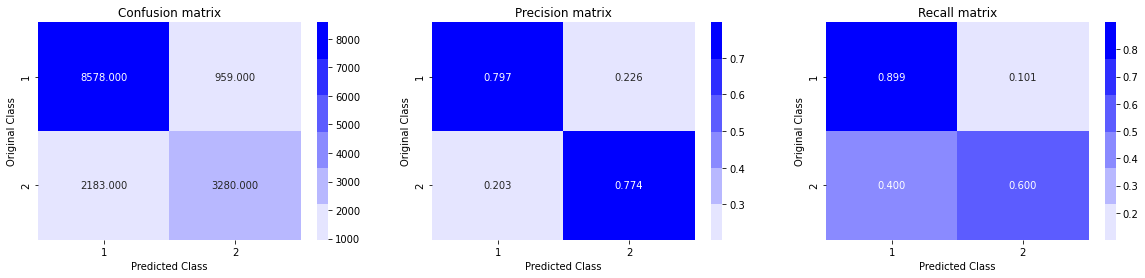

In [59]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_1, y_train)
    predict_y = sig_clf.predict_proba(x_test_1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_1, y_train)

predict_y = sig_clf.predict_proba(x_train_1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4384267333081892
For values of alpha =  0.0001 The log loss is: 0.4550717492246557
For values of alpha =  0.001 The log loss is: 0.47730633280651
For values of alpha =  0.01 The log loss is: 0.4941198490692562
For values of alpha =  0.1 The log loss is: 0.47653412833780295
For values of alpha =  1 The log loss is: 0.5757851619246297
For values of alpha =  10 The log loss is: 0.6402521133768251


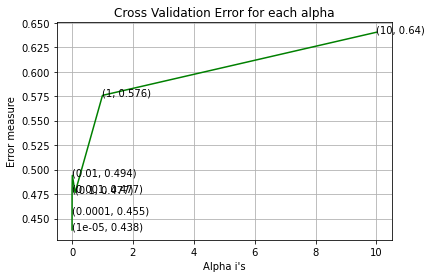

For values of best alpha =  1e-05 The train log loss is: 0.4261876875310936
For values of best alpha =  1e-05 The test log loss is: 0.4384267333081892
Total number of data points : 15000


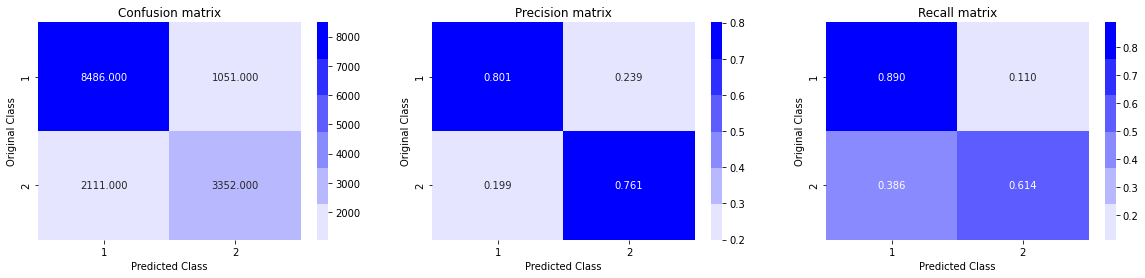

In [60]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train_1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_1, y_train)
    predict_y = sig_clf.predict_proba(x_test_1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train_1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_1, y_train)

predict_y = sig_clf.predict_proba(x_train_1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [0]:
import spacy
from tqdm import tqdm

In [75]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(q1_train)):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
q1_w2v_train = list(vecs1)

100%|██████████| 35000/35000 [03:58<00:00, 146.79it/s]


In [77]:
vecs2 = []
for qu2 in tqdm(list(q2_train)):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec2 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
q2_w2v_train = list(vecs2)

100%|██████████| 35000/35000 [03:54<00:00, 149.38it/s]


In [78]:
vecs2 = []
for qu2 in tqdm(list(q1_test)):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec2 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
q1_w2v_test = list(vecs2)

100%|██████████| 15000/15000 [01:37<00:00, 153.13it/s]


In [79]:
vecs2 = []
for qu2 in tqdm(list(q2_test)):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec2 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
q2_w2v_test = list(vecs2)

100%|██████████| 15000/15000 [01:37<00:00, 154.09it/s]


In [0]:
x_train_2 = hstack((X_train,q1_w2v_train,q2_w2v_train))
x_test_2 = hstack((X_test,q1_w2v_test,q2_w2v_test))

In [82]:
x_test_2.shape

(15000, 218)

In [88]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

params = {     
    'max_depth': [3, 4, 5, 6, 7, 8],       
    'eta' : [0.01, 0.02, 0.05, 0.1]   
         }

xgb = xgb.XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='neg_log_loss', return_train_score=True) 
random_search.fit(x_train_2, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [90]:
print('Best hyperparameters:')
print(random_search.best_params_)
eta = random_search.best_params_["eta"]
max_depth = random_search.best_params_["max_depth"]

Best hyperparameters:
{'max_depth': 7, 'eta': 0.01}


In [91]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = eta
params['max_depth'] = max_depth

d_train = xgb.DMatrix(x_train_2, label=y_train)
d_test = xgb.DMatrix(x_test_2, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train_2,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.688138	valid-logloss:0.688292
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.642962	valid-logloss:0.644643
[20]	train-logloss:0.605222	valid-logloss:0.608318
[30]	train-logloss:0.572987	valid-logloss:0.577381
[40]	train-logloss:0.545305	valid-logloss:0.551076
[50]	train-logloss:0.521306	valid-logloss:0.528418
[60]	train-logloss:0.500166	valid-logloss:0.508569
[70]	train-logloss:0.481614	valid-logloss:0.491249
[80]	train-logloss:0.46527	valid-logloss:0.476144
[90]	train-logloss:0.450801	valid-logloss:0.463028
[100]	train-logloss:0.437841	valid-logloss:0.451269
[110]	train-logloss:0.426559	valid-logloss:0.441111
[120]	train-logloss:0.416414	valid-logloss:0.432208
[130]	train-logloss:0.407256	valid-logloss:0.424311
[140]	train-logloss:0.398817	valid-logloss:0.41718
[150]	train-logloss:0.391062	valid-logloss:0.410762
[160]	train-logloss:0.383952	v

In [92]:
print("The test log loss is:", log_loss(y_test, predict_y, labels=random_search.classes_, eps=1e-15))

The test log loss is: 0.35392725638182215


Total number of data points : 15000


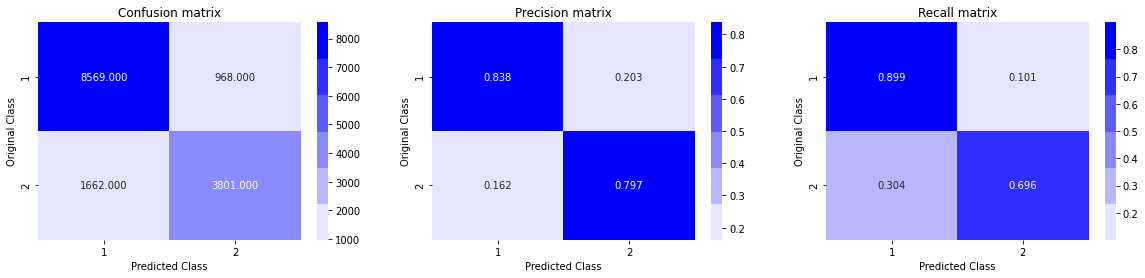

In [93]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Summary </h1>

In [95]:
from prettytable import PrettyTable
x = PrettyTable() 
x.field_names = ["Vectorizer", "Model", "Test log loss"] 
x.add_row(["TFIDF", "Random Model", 0.87]) 
x.add_row(["TFIDF", "Logistic Regression", 0.42])
x.add_row(["TFIDF", "Linear SVM", 0.43]) 
x.add_row(["TFIDF-Weighted-W2V", "XGBoost", 0.35])
print(x)

+--------------------+---------------------+---------------+
|     Vectorizer     |        Model        | Test log loss |
+--------------------+---------------------+---------------+
|       TFIDF        |     Random Model    |      0.87     |
|       TFIDF        | Logistic Regression |      0.42     |
|       TFIDF        |      Linear SVM     |      0.43     |
| TFIDF-Weighted-W2V |       XGBoost       |      0.35     |
+--------------------+---------------------+---------------+
